In [1]:
import string
import random
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import TimeDistributedDense, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import os
from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)
import numpy as np
from keras.utils import np_utils
from matplotlib import pyplot
from tempfile import mkdtemp
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import matplotlib.pyplot as plt
import theano
from keras.layers.wrappers import TimeDistributed
import keras
from  keras.optimizers import Adadelta
from scipy.misc import toimage
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout,Activation , initializations, regularizers, constraints
from keras.layers.convolutional import Convolution1D,Convolution2D, MaxPooling2D, ZeroPadding2D, MaxPooling1D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
%matplotlib inline
from keras import backend as K
from keras.layers import Merge
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from keras.utils import np_utils
from keras.engine.topology import Layer
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout, Reshape, Flatten
from keras.layers.recurrent import LSTM
import traceback
import re
import sys
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import random

%matplotlib inline

Using Theano backend.
Using gpu device 0: Quadro M6000 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN not available)
/home/sunil/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sunil/.local/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
stringSize = 100 # defining string size
maxWordLength = 100 

In [3]:
# lets consider 63 basic character, those occur the most
charToInt = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'A':10,'a':11,'B':12,'b':13,'C':14,'c':15,'D':16,'d':17,'E':18,'e':19,'F':20,'f':21,'G':22,'g':23,'H':24,'h':25,'I':26,'i':27,'J':28,'j':29,'K':30,'k':31,'L':32,'l':33,'M':34,'m':35,'N':36,'n':37,'O':38,'o':39,'P':40,'p':41,'Q':42,'q':43,'R':44,'r':45,'S':46,'s':47,'T':48,'t':49,'U':50,'u':51,'V':52,'v':53,'W':54,'w':55,'X':56,'x':57,'Y':58,'y':59,'Z':60,'z':61 ,' ':62,'.':63}

In [4]:
intToChar = {v: k for k, v in charToInt.iteritems()}

In [5]:
def string_generator(size=stringSize, chars=string.ascii_uppercase + string.digits):
    """
    will generate random string
    """
    return ''.join(random.choice(chars) for _ in range(size))

In [6]:
def makeRandomFragments(string):
    splitted = []
    prev = 0
    while True:
        n = random.randint(10,25)
        splitted.append(string[prev:prev+n])
        prev = prev + n
        if prev >= len(string)-1:
            break
    return "".join(list(set(splitted)))

In [7]:
def mutator(originalString, percentageMutation):
    """
    will take a string and mutate it as per percentage specified
    """
    originalStringArray = list(originalString)
    for i in range(percentageMutation):
        # print originalStringArray
        randomPlace = random.randint(0,len(originalString)-1)
        randomLetter = random.choice(string.letters)
        originalStringArray[randomPlace] = randomLetter
    return makeRandomFragments("".join(originalStringArray))

In [8]:
def giveWordmatrix(word):
    """
    will generate 2d matrix of the string, which will be an input to convolutional network
    word : is a string given to function
    """
    #2d matrix of size 100*63 initilaized with all cell having value "false"
    tempMatrix = np.zeros((maxWordLength, 63),dtype=bool)
    charNo=0
    for charNo in range (0,len(word)):
        if charNo<maxWordLength:
            try:
                try:
                    # for above defined 63 character, if character exists then "true" is placed in place 
                    characterToIndex = int(word[charNo])
                    tempMatrix[charNo][characterToIndex]=True
                    charNo += 1
                except:
                    characterToIndex = charToInt[word[charNo]]
                    tempMatrix[charNo][characterToIndex]=True
                    charNo += 1
            except:
                tempMatrix[charNo][0]=False
    
    return tempMatrix

In [9]:
# defining model

# model2 will take original string
model2 = Sequential()
model2.add(Convolution1D(64, 3, border_mode='same', input_shape=(100, 63,)))
model2.add(MaxPooling1D(pool_length=2))
model2.add(Convolution1D(nb_filter=128,filter_length=3,border_mode='valid',activation='relu'))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='sigmoid'))
# model2.summary()

# model1 will take mutated string
model1 = Sequential()
model1.add(Convolution1D(64, 3, border_mode='same', input_shape=(100, 63,)))
model1.add(MaxPooling1D(pool_length=2))
model1.add(Convolution1D(nb_filter=128,filter_length=3,border_mode='valid',activation='relu'))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(32, activation='sigmoid'))

# both model merges 
merged = Merge([model1, model2], mode='concat')
# final model will decide final result
final_model = Sequential()
final_model.add(merged)
final_model.add(Dense(64))
final_model.add(Activation('tanh'))
final_model.add(Dense(64))
final_model.add(Activation('tanh'))

final_model.add(Dense(100, activation='sigmoid'))
final_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_3 (Convolution1D)  (None, 100, 64)       12160       convolution1d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling1d_2 (MaxPooling1D)    (None, 50, 64)        0           convolution1d_3[0][0]            
____________________________________________________________________________________________________
convolution1d_4 (Convolution1D)  (None, 48, 128)       24704       maxpooling1d_2[0][0]             
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 6144)          0           convolution1d_4[0][0]            
___________________________________________________________________________________________

In [10]:
# compiling model
final_model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['mse'])

In [11]:
# lets do little visualization

# generating new string
originalString = string_generator()
# print originalString
# mutating the same string randomly
prcentageMutation = random.randint(0,100)
mutatedString = mutator(originalString,0)
# print mutatedString

# genearting 2d matrix for original string
originalStringMatrix = giveWordmatrix(originalString)
# genearting 2d matrix for mutated string
mutatedStringMatrix = giveWordmatrix(mutatedString)

Original String


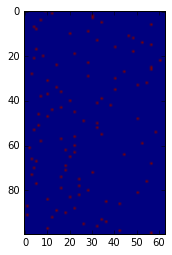

Mutated String


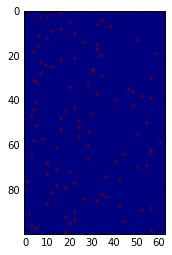

In [12]:
# visualizing original and muataed string
print ("Original String")
pyplot.imshow(toimage(originalStringMatrix)) #showing first image
pyplot.show()
print ("Mutated String")
pyplot.imshow(toimage(mutatedStringMatrix)) #showing first image
pyplot.show()

In [18]:
# file to watch intermediate results
testFileOut = open("intermediate_results.txt","w") 

# repeate for 5000 iterations, you may change this
for times in range(5000):
    originalStringArray  = [] # to keep original strings
    mutatedStringArray = [] # to keep mutated strings
    percentageSameArray = []
    response = [] # to keep percentage simillarity between original and mutated strings
    print times
    
    # every time new 10000 strings and their mutated strings are generated and kept in RAM
    for batchOf in range(10000):
        # generating origianl string
        originalString = string_generator()
        #randomly deciding percentage mutation
        prcentageMutation = random.randint(1,100)
        #100(stringSize) - mutation = percentage simillarity between original and muatated string
        percentageSame = 100-prcentageMutation
        percentageSameArray.append(percentageSame)
        #generating mutated string
        mutatedString = mutator(originalString,prcentageMutation)
        
        #generating original string matrix
        originalStringMatrix = giveWordmatrix(originalString)
        #appending original string matrix to originalStringArray
        #after 10000 loops, originalStringArray will be having marix for 10000 original strings
        originalStringArray.append(originalStringMatrix)
        
        #generating mutated string matrix
        mutatedStringMatrix = giveWordmatrix(mutatedString)
        #appending mutated string matrix to mutatedStringArray
        #after 10000 loops, mutatedStringArray will be having marix for 10000 muated strings
        mutatedStringArray.append(mutatedStringMatrix)
        
        #response vector is having %simillarity  between original and muatated string
        #after 10000 loops, response will be having % for above geenrated 10000 original and 
        #corrosponding mutated strings
        response.append(percentageSame)
        
    if times%1000 == 0:
        # at every 1000 iteration it will dump output to testFileOut; this is to see progress of learning
        #converting originalStringArray having 10000 strings to numpy boolean array
        originalStringArray =  np.asarray(originalStringArray,dtype = 'bool')
        # changed nothing in reshape; precautionary 
        originalStringArray = originalStringArray.reshape(originalStringArray.shape[0],originalStringArray.shape[1],originalStringArray.shape[2])
        
        #converting mutatedStringArray having 10000 mutated strings to numpy boolean array
        mutatedStringArray =  np.asarray(mutatedStringArray,dtype = 'bool')
        # changed nothing in reshape; precautionary 
        mutatedStringArray = mutatedStringArray.reshape(mutatedStringArray.shape[0], mutatedStringArray.shape[1],mutatedStringArray.shape[2])
        
        #converting respose vector to categorical "one hot encoding" 
        #when we use categorical_crossentropy as loss function, converting to "one hot encoding" is must.
        response = np_utils.to_categorical(response,100)
        
        # training
        final_model.fit([originalStringArray,mutatedStringArray],response,batch_size=10000,nb_epoch=1, verbose=2,validation_split=0.2)
        # getting probability for intermediate inspection
        prob =  final_model.predict_classes([originalStringArray,mutatedStringArray],verbose=0)
        
        # writting to file
        for eachNo in range(0,len(list(prob))):
            testFileOut.write(str(prob[eachNo])+"\t"+str(percentageSameArray[eachNo])+"\n")
        testFileOut.flush()
    else:
        # When in pection is not required
        #converting originalStringArray having 10000 strings to numpy boolean array
        originalStringArray =  np.asarray(originalStringArray,dtype = 'bool')
        # changed nothing in reshape; precautionary 
        originalStringArray = originalStringArray.reshape(originalStringArray.shape[0],originalStringArray.shape[1],originalStringArray.shape[2])
        #converting mutatedStringArray having 10000 mutated strings to numpy boolean array
        mutatedStringArray =  np.asarray(mutatedStringArray,dtype = 'bool')
        # changed nothing in reshape; precautionary 
        mutatedStringArray = mutatedStringArray.reshape(mutatedStringArray.shape[0], mutatedStringArray.shape[1],mutatedStringArray.shape[2])
        
        #converting respose vector to categorical "one hot encoding" 
        #when we use categorical_crossentropy as loss function, converting to "one hot encoding" is must.
        response = np_utils.to_categorical(response,100)
        # training
        final_model.fit([originalStringArray,mutatedStringArray],response,batch_size=10000,nb_epoch=1, verbose=1,validation_split=0.2)

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
4s - loss: 3.4137 - mean_squared_error: 0.0207 - val_loss: 3.8313 - val_mean_squared_error: 0.0187
1
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 4s - loss: 3.4267 - mean_squared_error: 0.0200 - val_loss: 3.8947 - val_mean_squared_error: 0.0192
2
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 4s - loss: 3.6272 - mean_squared_error: 0.0210 - val_loss: 6.4638 - val_mean_squared_error: 0.0414
3
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 4s - loss: 6.6046 - mean_squared_error: 0.0465 - val_loss: 5.9166 - val_mean_squared_error: 0.0307
4
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 4s - loss: 6.0484 - mean_squared_error: 0.0358 - val_loss: 6.4429 - val_mean_squared_error: 0.0384
5
Train on 8000 samples, 

In [19]:
# to save model
# final_model.save_weights("string_matching_translocation.h5")

In [17]:
# to load model
# final_model.load_weights("string_matching.h5")

In [20]:
# testing on random 100 strings
for i in range(100):
    # gerate new original string
    originalString = string_generator()
    # generated mutated string
    prcentageMutation = random.randint(0,99)
    percentageSame = 100-prcentageMutation
    mutatedString = mutator(originalString,prcentageMutation)
    
    #Get numpy matrrix for original And muuated string
    originalStringMatrix_test = giveWordmatrix(originalString)
    mutatedStringMatrix_test = giveWordmatrix(mutatedString)

    # reshaping to meet dimension requirement
    originalStringArray = originalStringMatrix_test.reshape(1,originalStringMatrix_test.shape[0],originalStringMatrix_test.shape[1])
    mutatedStringArray = mutatedStringMatrix_test.reshape(1, mutatedStringMatrix_test.shape[0],mutatedStringMatrix_test.shape[1])
#     print "Original String :",originalString
#     print "Mutated String :",mutatedString
#     # printing 
    print originalString,"\t",mutatedString,"\t","Predicted:\t",final_model.predict_classes([originalStringArray,mutatedStringArray],verbose=0)[0],"\tOriginal\t",percentageSame,"\t Levenshtein Distance\t", fuzz.token_sort_ratio(originalString,mutatedString)

3Z27ILZKMISAQVJKZ2WD7WPIJFIMUCFBJQ267SWAYPUZ8XT35LSEMBB5QQ24J0XV472DBM0T5PC8EK5HS75YEKHD2TZEYN2D26A5 	BJY267XWAYPUZ8XEKHnmTZLYf2DX6A5Tp5LSEMBddQQ24J0XV47WyzTiIMUXA3Si7ILZcMISAQVsKeAWkoJDBq0T5PCtEKNHS7JY 	Predicted:	58 	Original	66 	 Levenshtein Distance	43
6H0JRH6PF2FTZGVED9PY910GBBGDUGSOZF9NIRMZYV2LPLSMLALCH0P28CEW47GTO0ONCXQH43D2R3K55J9UL1KDVNANQ2T9HGMK 	rRMZYV2LPLSMvALCH0N2ErEW47GTOROrpZQHV36H0JRtWPF2FTD2R3K55JAUL1KDZtVEDWkY91EGIeGaUGSOgi9NVNANG2TKHGMK 	Predicted:	69 	Original	67 	 Levenshtein Distance	52
FGDBUP9D5ELBSU5PXQ3PCYSFXSCLPCQKUMV7D5YJAO5U5UMH1D9E17N9WTQRKCHJT0DM1G8Y8T62RZ3OQ3OWGF6W97MRDYAXZHBD 	dGUgUNTA5ELLIUMPRQ3PCYSFrSCmPCOnUMAjh5YlTQOKujisDDM1G8Y8T62Tl3UQJLOcg5UpBxD9J1dNS3OYhGHjvhMaDXAfYOBD 	Predicted:	42 	Original	30 	 Levenshtein Distance	37
ROENSREMBEILEZBA978U9S6Z1BSQYC6PV99C37P5X6PB8XAP4L72PKQ1Y99I9MZNNLV1I9TE2AUP8G0WBC2DFQCDC5KAXF0WO4BA 	XF0Wa4DA5U6PBKXAP4L72PtQ1w9G0bzC2DFQCDCmKA9w8U9S6a1BSEYz6LM99CxyPROEhSRgMBEIXEVUAGI9MZNNLV1zuNEfAUP8 	Predicted:	63 	Original	6

39


In [62]:
import random
string = '123456789'
def makeRandomFragments(string):
    splitted = []
    prev = 0
    while True:
        n = random.randint(1,3)
        splitted.append(string[prev:prev+n])
        prev = prev + n
        if prev >= len(string)-1:
            break
    return "".join(list(set(splitted)))

In [63]:
makeRandomFragments(string)

'56127834'